# Nifty Behavior
When nifty opens too high or too low, does it maintain the direction throughout the day and for how long?
- How often nifty moves up and how often it moves down?
- In market shock, does market behave in a certain way?

In [16]:
import datetime as dt
import utils as ut
import pandas as pd
import icharts as ic
from functools import cache
from constants import *


TEST_START = dt.datetime.strptime("2015-02-01", "%Y-%m-%d")
TEST_START = dt.datetime.strptime("2021-01-01", "%Y-%m-%d")
TEST_END = dt.datetime.strptime("2023-02-27", "%Y-%m-%d")
SYMBOL = "NIFTY 50"
IC_SYMBOL = "NIFTY"
INTERVAL = ut.INTERVAL_MIN60
EXCHANGE = ut.EXCHANGE_NSE
pickle_file_name = "ocdf_2024_02_17.pkl"
# pickle_file_name = "test_analyzer_ocdf_2024_02_17.pkl"

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 200)
# pd.set_option('precision', 2)
pd.set_option("display.precision", 2)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)

def build_date_range(date_start, date_end, symbol):
    date_range = []
    cur_date = date_start
    while cur_date < date_end:
        if cur_date.weekday() not in [5, 6]:
            has_data, _ = ut.has_data(symbol, cur_date, interval=INTERVAL, exchange=EXCHANGE)
            if has_data:
                date_range.append(cur_date)
        cur_date += dt.timedelta(days=1)
    return date_range

all_dates = pd.DataFrame({"trade_date": build_date_range(TEST_START, TEST_END, SYMBOL)})
all_dates_shuffled = all_dates.sample(frac=1, random_state=42)

train_size = int(0.5 * len(all_dates_shuffled))
train_dates = all_dates_shuffled.iloc[:train_size]
train_dates = all_dates
test_dates = all_dates_shuffled.iloc[train_size:]
train_dates = train_dates.sort_values(by="trade_date")
train_dates.set_index("trade_date", inplace=True)
test_dates = test_dates.sort_values(by="trade_date")
test_dates.set_index("trade_date", inplace=True)

def get_last_trading_day(date):
    return ut.get_last_trading_day(SYMBOL, date, interval=INTERVAL, exchange=ut.EXCHANGE_NSE)

def get_symbol_first_candle_open(symbol, trade_date):
    data = ut.get_data(symbol=SYMBOL, date=trade_date, interval=INTERVAL, exchange=EXCHANGE)
    return data.iloc[0].open

def get_symbol_last_candle_close(symbol, trade_date):
    data = ut.get_data(symbol=SYMBOL, date=trade_date, interval=INTERVAL, exchange=EXCHANGE)
    return data.iloc[-1].close

train_dates["previous_trading_day"] = None
train_dates["previous_trading_day"] = train_dates.apply(lambda row: get_last_trading_day(row.name), axis=1)
train_dates["pd_close"] = train_dates.apply(lambda row: get_symbol_last_candle_close(SYMBOL, row.previous_trading_day), axis=1)
train_dates["td_open"] = train_dates.apply(lambda row: get_symbol_first_candle_open(SYMBOL, row.name), axis=1)
train_dates["td_close"] = train_dates.apply(lambda row: get_symbol_last_candle_close(SYMBOL, row.name), axis=1)
train_dates["market_move"] = train_dates.td_close - train_dates.td_open
train_dates["gap"] = train_dates.td_open - train_dates.pd_close

In [2]:
print(f"Up: {train_dates.loc[train_dates.td_pd_diff >= 0].shape[0]}/{train_dates.shape[0]}")
print(f"Up PC: {train_dates.loc[train_dates.td_pd_diff >= 0].shape[0] * 100/ train_dates.shape[0]}")
print(f"Avg UP: {train_dates.loc[train_dates.td_pd_diff >= 0].td_pd_diff.mean()}")
print(f"Down: {train_dates.loc[train_dates.td_pd_diff < 0].shape[0]}/{train_dates.shape[0]}")
print(f"Down PC: {train_dates.loc[train_dates.td_pd_diff < 0].shape[0] * 100/ train_dates.shape[0]}")
print(f"Avg DOWN: {train_dates.loc[train_dates.td_pd_diff < 0].td_pd_diff.mean()}")

Up: 260/370
Up PC: 70.27027027027027
Avg UP: 66.65826923076929
Down: 110/370
Down PC: 29.72972972972973
Avg DOWN: -83.47545454545438


In [11]:
print(train_dates[train_dates.market_move > 0].shape[0] / train_dates.shape[0])
print(train_dates[train_dates.market_move < 0].shape[0] / train_dates.shape[0])

0.5081081081081081
0.4918918918918919


In [18]:
train_dates["trade_date"] = train_dates.index.values
gdf = train_dates.groupby(pd.Grouper(key="trade_date", freq="ME"))
for month, mdf in gdf:
    print(f"Month: {month}, moveup: {round(mdf[mdf.market_move > 0].shape[0] / mdf.shape[0], 2)}, move_down: {round(mdf[mdf.market_move < 0].shape[0] / mdf.shape[0], 2)}")


Month: 2021-01-31 00:00:00, moveup: 0.67, move_down: 0.33
Month: 2021-02-28 00:00:00, moveup: 0.44, move_down: 0.56
Month: 2021-03-31 00:00:00, moveup: 0.58, move_down: 0.42
Month: 2021-04-30 00:00:00, moveup: 0.57, move_down: 0.43
Month: 2021-05-31 00:00:00, moveup: 0.64, move_down: 0.36
Month: 2021-06-30 00:00:00, moveup: 0.67, move_down: 0.33
Month: 2021-07-31 00:00:00, moveup: 0.5, move_down: 0.5
Month: 2021-08-31 00:00:00, moveup: 0.62, move_down: 0.38
Month: 2021-09-30 00:00:00, moveup: 0.36, move_down: 0.64
Month: 2021-10-31 00:00:00, moveup: 0.11, move_down: 0.89
Month: 2021-11-30 00:00:00, moveup: 0.36, move_down: 0.64
Month: 2021-12-31 00:00:00, moveup: 0.4, move_down: 0.6
Month: 2022-01-31 00:00:00, moveup: 0.67, move_down: 0.33
Month: 2022-02-28 00:00:00, moveup: 0.67, move_down: 0.33
Month: 2022-03-31 00:00:00, moveup: 0.5, move_down: 0.5
Month: 2022-04-30 00:00:00, moveup: 0.6, move_down: 0.4
Month: 2022-05-31 00:00:00, moveup: 0.38, move_down: 0.62
Month: 2022-06-30 00:0

In [19]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

train_dates["rolling_move"] = train_dates.market_move
train_dates["rolling_move_gap"] = train_dates.gap + train_dates.market_move

for i, row in train_dates.iterrows():
    # Update the value of the current row using the value of the previous row
    prev_row = train_dates.shift(1).loc[i]
    if not pd.isnull(prev_row.pd_close):
        train_dates.at[i, "rolling_move"] = prev_row.rolling_move + row["market_move"]
        train_dates.at[i, "rolling_move_gap"] = prev_row.rolling_move_gap + row["market_move"] + row.gap
        train_dates.at[i, "rolling_gap"] = prev_row.gap + row.gap

# train_dates["rolling_move"] = train_dates.rolling_move.rolling(window=2).apply(set_move)
train_dates

,previous_trading_day,pd_close,td_open,td_close,market_move,gap,rolling_move,rolling_move_gap,rolling_gap
trade_date,,,,,,,,,
2021-01-01,2020-12-31,13967.00,13996.10,14014.80,18.70,29.10,18.70,47.80,NaN
2021-01-04,2021-01-01,14014.80,14104.35,14143.65,39.30,89.55,58.00,176.65,118.65
2021-01-05,2021-01-04,14143.65,14075.15,14199.30,124.15,-68.50,182.15,232.30,21.05
2021-01-06,2021-01-05,14199.30,14240.95,14134.05,-106.90,41.65,75.25,167.05,-26.85
2021-01-07,2021-01-06,14134.05,14253.75,14148.45,-105.30,119.70,-30.05,181.45,161.35
2021-01-08,2021-01-07,14148.45,14258.40,14343.90,85.50,109.95,55.45,376.90,229.65
2021-01-11,2021-01-08,14343.90,14474.05,14483.05,9.00,130.15,64.45,516.05,240.10
2021-01-12,2021-01-11,14483.05,14473.80,14574.75,100.95,-9.25,165.40,607.75,120.90
2021-01-13,2021-01-12,14574.75,14639.80,14558.30,-81.50,65.05,83.90,591.30,55.80


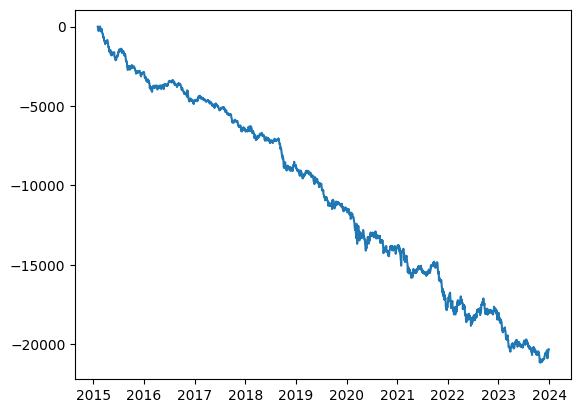

In [8]:
import matplotlib.pyplot as plt

train_dates["rmg_pc"] = train_dates.rolling_move_gap * 100 / train_dates.td_open
plt.plot(train_dates.rolling_move)
# plt.plot(train_dates.rmg_pc)

In [11]:
train_dates["trade_date"] = train_dates.index.values
gdf = train_dates.groupby(pd.Grouper(key="trade_date", freq="ME"))
for month, mdf in gdf:
    print(f"Month: {month}, moveup: {round(mdf[mdf.market_move > 10].shape[0] / mdf.shape[0], 2)}, move_down: {round(mdf[mdf.market_move < 0].shape[0] / mdf.shape[0], 2)}")
    # print(f"Month: {month}, moveup: {round(mdf[mdf.market_move > 10].shape[0] / mdf.shape[0], 2)}, move_down: {round(mdf[mdf.market_move < 0].shape[0] / mdf.shape[0], 2)}")


Month: 2015-02-28 00:00:00, moveup: 0.37, move_down: 0.63
Month: 2015-03-31 00:00:00, moveup: 0.24, move_down: 0.67
Month: 2015-04-30 00:00:00, moveup: 0.37, move_down: 0.63
Month: 2015-05-31 00:00:00, moveup: 0.5, move_down: 0.45
Month: 2015-06-30 00:00:00, moveup: 0.45, move_down: 0.41
Month: 2015-07-31 00:00:00, moveup: 0.43, move_down: 0.57
Month: 2015-08-31 00:00:00, moveup: 0.24, move_down: 0.67
Month: 2015-09-30 00:00:00, moveup: 0.45, move_down: 0.45
Month: 2015-10-31 00:00:00, moveup: 0.2, move_down: 0.65
Month: 2015-11-30 00:00:00, moveup: 0.32, move_down: 0.58
Month: 2015-12-31 00:00:00, moveup: 0.41, move_down: 0.55
Month: 2016-01-31 00:00:00, moveup: 0.3, move_down: 0.65
Month: 2016-02-29 00:00:00, moveup: 0.24, move_down: 0.62
Month: 2016-03-31 00:00:00, moveup: 0.55, move_down: 0.45
Month: 2016-04-30 00:00:00, moveup: 0.44, move_down: 0.5
Month: 2016-05-31 00:00:00, moveup: 0.5, move_down: 0.41
Month: 2016-06-30 00:00:00, moveup: 0.5, move_down: 0.45
Month: 2016-07-31 00

In [20]:
# train_dates.loc[train_dates.index.date >= dt.date(year=2021, month=1, day=1)]
train_dates

,previous_trading_day,pd_close,td_open,td_close,market_move,gap,rolling_move,rolling_move_gap,rolling_gap
trade_date,,,,,,,,,
2021-01-01,2020-12-31,13967.00,13996.10,14014.80,18.70,29.10,18.70,47.80,NaN
2021-01-04,2021-01-01,14014.80,14104.35,14143.65,39.30,89.55,58.00,176.65,118.65
2021-01-05,2021-01-04,14143.65,14075.15,14199.30,124.15,-68.50,182.15,232.30,21.05
2021-01-06,2021-01-05,14199.30,14240.95,14134.05,-106.90,41.65,75.25,167.05,-26.85
2021-01-07,2021-01-06,14134.05,14253.75,14148.45,-105.30,119.70,-30.05,181.45,161.35
2021-01-08,2021-01-07,14148.45,14258.40,14343.90,85.50,109.95,55.45,376.90,229.65
2021-01-11,2021-01-08,14343.90,14474.05,14483.05,9.00,130.15,64.45,516.05,240.10
2021-01-12,2021-01-11,14483.05,14473.80,14574.75,100.95,-9.25,165.40,607.75,120.90
2021-01-13,2021-01-12,14574.75,14639.80,14558.30,-81.50,65.05,83.90,591.30,55.80
